<a href="https://colab.research.google.com/github/satwik-goyal/Robotics-CIFAR100-Classification/blob/main/CR_CWK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras

In [1]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Reshape , Multiply, Activation
from tensorflow.keras.layers import Input, DepthwiseConv2D, GlobalAveragePooling2D , Add, UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.legacy import RMSprop, Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from keras.models import Model
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
%pip install keras-tuner --upgrade
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [3]:


 # Load CIFAR100 dataset
from tensorflow.keras.datasets import cifar100
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# # Normalize pixel values
# X_train = X_train.astype('float32') / 255
# X_test = X_test.astype('float32') / 255
x_train = preprocess_input(X_train)
x_test = preprocess_input(X_test)


# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)




169001437/169001437 [==============================] - 6s 0us/step


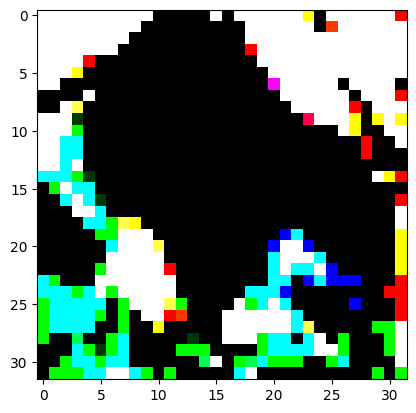

In [4]:
Selected_Image = 13422
image = x_train[Selected_Image]
plt.imshow(image)
plt.show()


## Pretrained

In [36]:
class ResNetModel(kt.HyperModel):

  def build(self, hp):
      base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

      for layer in base_model.layers:
          if isinstance(layer, BatchNormalization):
              layer.trainable = True
          else:
              layer.trainable = False

      model = Sequential()
      model.add(UpSampling2D())
      model.add(UpSampling2D())
      model.add(UpSampling2D())
      model.add(base_model)
      model.add(GlobalAveragePooling2D())
      model.add(Dense(256, activation='relu'))
      model.add(Dropout(0.25))
      model.add(BatchNormalization())
      model.add(Dense(100, activation='softmax'))

      # learning_rate = hp.Choice("learning_rate", values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
      weight_decay = hp.Choice("weight_decay" , values = [0.0, 1e-4, 5e-4, 1e-3, 5e-3])
      optimizer = Adam(learning_rate=0.001 , decay = weight_decay)
      model.compile(optimizer=optimizer, metrics=["accuracy"], loss='categorical_crossentropy')
      return model

  def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=64,
            **kwargs,
        )
        #hp.Choice("batch_size", [32, 64,128])

In [15]:
# Tuner for Learning Rate
# tuner_lr = kt.GridSearch(ResNetModel(),objective = "val_loss" , max_trials = 5, directory = "evaluation" , project_name = "learning_rate" )
# tuner_lr.search(x_train, y_train, epochs = 10, validation_data = (x_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=2)])


In [ ]:
# !zip -r /content/learning_rate.zip /content/evaluation/learning_rate/

In [19]:
# tuner_lr.get_best_hyperparameters(num_trials=5)[0].get("learning_rate")

0.001

In [29]:
# Tuner for batch size

# tuner_bs = kt.GridSearch(ResNetModel(),objective = "val_loss" , max_trials = 5, directory = "evaluation" , project_name = "batch_size" )
# tuner_bs.search(x_train, y_train, epochs = 10, validation_data = (x_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=2)])

In [37]:
# Tuner for weight decay

tuner_wd = kt.GridSearch(ResNetModel(),objective = "val_loss" , max_trials = 5, directory = "evaluation" , project_name = "weight_decay" )
tuner_wd.search(x_train, y_train, epochs = 10, validation_data = (x_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=2)])

Trial 5 Complete [00h 25m 57s]
val_loss: 0.8355650305747986

Best val_loss So Far: 0.7105887532234192
Total elapsed time: 01h 56m 38s
